# 3. Modelos del lenguaje (estadísticos) y Vectores de palabras


![](https://www.ruder.io/content/images/size/w2000/2016/04/word_embeddings_colah.png)

## Objetivo

- Implementar modelos del lenguaje estadísticos
    - Aplicaciones
- Explorar representaciones vectoriales de palabras
    - Count-based DSMs
    - Word2Vec
- Manipulación de vectores pre-entrenados
- Entrenar representaciones usando `gensim`

## Modelos del lenguaje

> Un modelo del lenguaje es un modelo estadístico que asigna probabilidades a cadenas dentro de un lenguaje - Jurafsky, 2000

$$ \mu = (\Sigma, A, \Pi)$$

Donde:
- $\mu$ es el modelo del lenguaje
- $\Sigma$ es el vocabulario
- $A$ es el tensor que guarda las probabilidades
- $\Pi$ guarda las probabilidades iniciales

- Este modelo busca estimar la probabilidad de una secuencia de tokens
- Pueden ser palabras, caracteres o tokens
- Se pueden considerar varios escenarios para la creación de estos modelos
    - Si podemos estimar la probabilidad de una unidad lingüística (palabras, tokens, oracines, etc), podemos usarlar de formas insospechadas

### I saw a cat in a mat

<img src="https://lena-voita.github.io/resources/lectures/lang_models/general/i_saw_a_cat_prob.gif">

### De los bigramas a los n-gramas

- Para bigramas tenemos la propiedad de Markov
- Para $n > 2$ las palabras dependen de mas elementos
    - Trigramas
    - 4-gramas
- En general para un modelo de n-gramas se toman en cuenta $n-1$ elementos

### Programando nuestros modelos del lenguaje

Utilizaremos un [corpus](https://www.nltk.org/book/ch02.html) en inglés disponible en NLTK

In [60]:
import nltk
nltk.download('gutenberg')
nltk.download('punkt_tab')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [61]:
import numpy as np
from nltk import ngrams
from nltk.corpus import gutenberg
from collections import Counter, defaultdict
from rich import print as rprint

In [62]:
# Exploración del corpus
rprint(len(gutenberg.sents()))
rprint(gutenberg.sents()[10])

98552

[
    'The',
    'danger',
    ',',
    'however',
    ',',
    'was',
    'at',
    'present',
    'so',
    'unperceived',
    ',',
    'that',
    'they',
    'did',
    'not',
    'by',
    'any',
    'means',
    'rank',
    'as',
    'misfortunes',
    'with',
    'her',
    '.'
]

In [63]:
import re

def preprocess_sent(sent: list[str]) -> list[str]:
    """Función de preprocesamiento

    Agrega tokens de inicio y fin a la oración y normaliza todo a minusculas

    Params
    ------
    sent: list[str]
        Lista de palabras que componen la oración

    Return
    ------
    Las oración preprocesada
    """
    result = [word.lower() for word in sent]
    # Al final de la oración
    result.append("</s>")
    # Al inicio de la oración
    result.insert(0, "<s>")
    
    return result

In [64]:
rprint(preprocess_sent(gutenberg.sents()[0]))

['<s>', '[', 'emma', 'by', 'jane', 'austen', '1816', ']', '</s>']

In [65]:
for i, sent in enumerate(gutenberg.sents()[:10]):
    rprint(i, " ".join(sent))

0 [ Emma by Jane Austen 1816 ]

1 VOLUME I

2 CHAPTER I

3 Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite 
some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to 
distress or vex her .

4 She was the youngest of the two daughters of a most affectionate , indulgent father ; and had , in consequence of
her sister ' s marriage , been mistress of his house from a very early period .

5 Her mother had died too long ago for her to have more than an indistinct remembrance of her caresses ; and her 
place had been supplied by an excellent woman as governess , who had fallen little short of a mother in affection .

6 Sixteen years had Miss Taylor been in Mr . Woodhouse ' s family , less as a governess than a friend , very fond 
of both daughters , but particularly of Emma .

7 Between _them_ it was more the intimacy of sisters .

8 Even before Miss Taylor had ceased to hold the nominal office of governess , the mildness of her temper had 
hardly allowed her to impose any restraint ; and the shadow of authority being now long passed away , they had been
living together as friend and friend very mutually attached , and Emma doing just what she liked ; highly esteeming
Miss Taylor ' s judgment , but directed chiefly by her own .

9 The real evils , indeed , of Emma ' s situation were the power of having rather too much her own way , and a 
disposition to think a little too well of herself ; these were the disadvantages which threatened alloy to her many
enjoyments .

In [66]:
for i, sent in enumerate(gutenberg.sents()[:10]):
    rprint(i, " ".join(preprocess_sent(sent)))

0 <s> [ emma by jane austen 1816 ] </s>

1 <s> volume i </s>

2 <s> chapter i </s>

3 <s> emma woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to 
unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very 
little to distress or vex her . </s>

4 <s> she was the youngest of the two daughters of a most affectionate , indulgent father ; and had , in 
consequence of her sister ' s marriage , been mistress of his house from a very early period . </s>

5 <s> her mother had died too long ago for her to have more than an indistinct remembrance of her caresses ; and 
her place had been supplied by an excellent woman as governess , who had fallen little short of a mother in 
affection . </s>

6 <s> sixteen years had miss taylor been in mr . woodhouse ' s family , less as a governess than a friend , very 
fond of both daughters , but particularly of emma . </s>

7 <s> between _them_ it was more the intimacy of sisters . </s>

8 <s> even before miss taylor had ceased to hold the nominal office of governess , the mildness of her temper had 
hardly allowed her to impose any restraint ; and the shadow of authority being now long passed away , they had been
living together as friend and friend very mutually attached , and emma doing just what she liked ; highly esteeming
miss taylor ' s judgment , but directed chiefly by her own . </s>

9 <s> the real evils , indeed , of emma ' s situation were the power of having rather too much her own way , and a 
disposition to think a little too well of herself ; these were the disadvantages which threatened alloy to her many
enjoyments . </s>

In [67]:
for ngram in list(ngrams(preprocess_sent(gutenberg.sents()[10]), 3))[:10]:
    rprint(ngram)

('<s>', 'the', 'danger')

('the', 'danger', ',')

('danger', ',', 'however')

(',', 'however', ',')

('however', ',', 'was')

(',', 'was', 'at')

('was', 'at', 'present')

('at', 'present', 'so')

('present', 'so', 'unperceived')

('so', 'unperceived', ',')

### Construyendo el modelo del lenguaje

![](https://imgs.xkcd.com/comics/predictive_models_2x.png)

In [68]:
test = defaultdict(Counter)

In [69]:
test[("hola", "que")]["hace"] += 1

In [70]:
test[("hola", "que")]

Counter({'hace': 1})

In [71]:
def build_trigram_model(data: list[list[str]]) -> defaultdict:
    # Initialize model as a nested dict with default behavior
    model = defaultdict(Counter)
    for sentence in data:
        for w1, w2, w3 in ngrams(preprocess_sent(sentence), 3):
            model[(w1, w2)][w3] += 1
    return model

In [72]:
trigram_model = build_trigram_model(gutenberg.sents())

In [73]:
trigram_model["<s>", "the"]

Counter({'little': 96,
         'first': 62,
         'man': 53,
         'next': 44,
         'old': 43,
         'two': 39,
         'other': 37,
         'professor': 27,
         'king': 25,
         'only': 24,
         'whole': 22,
         'rest': 21,
         'young': 20,
         'very': 20,
         'doctor': 20,
         'great': 19,
         'poor': 19,
         'same': 17,
         'second': 17,
         'lord': 17,
         'sun': 17,
         'whale': 17,
         'attorney': 17,
         'priest': 16,
         'white': 16,
         'moment': 15,
         'boy': 14,
         'last': 14,
         'book': 14,
         'three': 14,
         'idea': 12,
         'more': 12,
         'others': 12,
         'lady': 12,
         'wind': 12,
         'third': 12,
         'face': 12,
         'earth': 12,
         'children': 11,
         'morning': 11,
         'miss': 11,
         'girl': 11,
         'secretary': 11,
         'ship': 11,
         'most': 10,
         'evening

### Calculo de probabilidades con conteos de trigramas

In [74]:
for i, key in enumerate(trigram_model):
    rprint(key)
    if i == 5:
        break

('<s>', '[')

('[', 'emma')

('emma', 'by')

('by', 'jane')

('jane', 'austen')

('austen', '1816')

In [75]:
def calculate_model_probs(model: defaultdict[Counter]) -> defaultdict[Counter]:
    model_probs = defaultdict(Counter)
    # Por cada prefijo del modelo
    for prefix in model:
        # Todas las veces que ocurre prefix seguido de cualquier palabra
        total=float(sum(model[prefix].values()))
        # Por cada palabra w que haya ocurrido con prefix
        for w in model[prefix]:
            # Obtenemos la probabilidad
            model_probs[prefix][w] = model[prefix][w] / total
    return model_probs

#### Pregunta: ¿Cómo agregamos smoothing?

In [76]:
VOCABULARY = set([word.lower() for sent in gutenberg.sents() for word in sent])
# +2 por los tokens <s> y </s>
VOCABULARY_SIZE = len(VOCABULARY) + 2

In [77]:
def calculate_smooth_probs(model: defaultdict[Counter]) -> defaultdict[Counter]:
    model_probs = defaultdict(Counter)
    for prefix in model:
        total = float(sum(model[prefix].values()))
        for w in model[prefix]:
            model_probs[prefix][w] = (model[prefix][w] + 1) / (total + VOCABULARY_SIZE)
    return model_probs

In [78]:
trigram_probs = calculate_model_probs(trigram_model)

In [79]:
trigram_smooth = calculate_smooth_probs(trigram_model)

In [80]:
sorted(dict(trigram_probs["<s>","the"]).items(), key=lambda x:-1*x[1])

[('little', 0.025593175153292454),
 ('first', 0.01652892561983471),
 ('man', 0.014129565449213543),
 ('next', 0.011730205278592375),
 ('old', 0.011463609704078913),
 ('two', 0.01039722740602506),
 ('other', 0.009864036256998134),
 ('professor', 0.007198080511863503),
 ('king', 0.006664889362836577),
 ('only', 0.006398293788323114),
 ('whole', 0.005865102639296188),
 ('rest', 0.005598507064782724),
 ('young', 0.005331911490269262),
 ('very', 0.005331911490269262),
 ('doctor', 0.005331911490269262),
 ('great', 0.005065315915755798),
 ('poor', 0.005065315915755798),
 ('same', 0.0045321247667288725),
 ('second', 0.0045321247667288725),
 ('lord', 0.0045321247667288725),
 ('sun', 0.0045321247667288725),
 ('whale', 0.0045321247667288725),
 ('attorney', 0.0045321247667288725),
 ('priest', 0.004265529192215409),
 ('white', 0.004265529192215409),
 ('moment', 0.0039989336177019465),
 ('boy', 0.003732338043188483),
 ('last', 0.003732338043188483),
 ('book', 0.003732338043188483),
 ('three', 0.0037

In [81]:
sorted(dict(trigram_smooth["<s>","the"]).items(), key=lambda x:-1*x[1])

[('little', 0.0021054916431517256),
 ('first', 0.0013674842630779249),
 ('man', 0.001172129368352507),
 ('next', 0.0009767744736270893),
 ('old', 0.0009550683742131538),
 ('two', 0.0008682439765574126),
 ('other', 0.000824831777729542),
 ('professor', 0.0006077707835901888),
 ('king', 0.0005643585847623183),
 ('only', 0.0005426524853483829),
 ('whole', 0.0004992402865205123),
 ('rest', 0.0004775341871065769),
 ('young', 0.00045582808769264164),
 ('very', 0.00045582808769264164),
 ('doctor', 0.00045582808769264164),
 ('great', 0.0004341219882787063),
 ('poor', 0.0004341219882787063),
 ('same', 0.0003907097894508357),
 ('second', 0.0003907097894508357),
 ('lord', 0.0003907097894508357),
 ('sun', 0.0003907097894508357),
 ('whale', 0.0003907097894508357),
 ('attorney', 0.0003907097894508357),
 ('priest', 0.00036900369003690036),
 ('white', 0.00036900369003690036),
 ('moment', 0.0003472975906229651),
 ('boy', 0.00032559149120902974),
 ('last', 0.00032559149120902974),
 ('book', 0.0003255914

### Aplicaciones

- Speech To Text (STT)
- Completado de texto
- Generación de texto

![](https://lena-voita.github.io/resources/lectures/lang_models/examples/suggest-min.png)
Tomado de [Lena Voita](https://lena-voita.github.io/nlp_course/language_modeling.html)

In [82]:
def get_likely_words(
        model_probs: defaultdict[Counter],
        context: str,
        top_count: int=10) -> list[tuple]:
    """Dado un contexto obtiene las palabras más probables

    Params
    ------
    model_probs: defaultdict
        Probabilidades del modelo
    context: str
        Contexto con el cual calcular las palabras más probables siguientes
    top_count: int
        Cantidad de palabras más probables. Default 10
    """
    history = tuple(context.split())
    return sorted(dict(model_probs[history]).items(), key=lambda prob: -1*prob[1])[:top_count]

In [83]:
get_likely_words(trigram_probs, "<s> the", top_count=3)

[('little', 0.025593175153292454),
 ('first', 0.01652892561983471),
 ('man', 0.014129565449213543)]

In [84]:
from random import randint

def get_next_word(words: list) -> str:
    # Strategy here
    return words[0][0]

def get_next_random_word(words: list) -> str:
    return words[randint(0, len(words)-1)][0]

In [85]:
get_next_word(get_likely_words(trigram_probs, "emma was", 50))

'obliged'

In [86]:
sentence = "<s> the"
for i in range(10):
    print(i,
          get_next_random_word(get_likely_words(trigram_probs,
                                                sentence,
                                                50
                                                )
          )
    )

0 other
1 wind
2 very
3 professor
4 poor
5 next
6 last
7 last
8 most
9 white


#### Ejercicio: Utilizando el modelo de trigramas, diseña una estrategia para generación del lenguaje

In [87]:
import time
import random
MAX_TOKENS = 50

def generate_text(
        model: defaultdict[Counter],
        history: str, tokens_count: int = 0, top_n: int = 50):
    next_word = get_next_random_word(
        get_likely_words(model, history, top_count=10)
        )
    time.sleep(random.random())
    print(next_word, end=" ")
    tokens_count += 1
    if tokens_count == MAX_TOKENS or next_word == "</s>":
        return
    return generate_text(
        model,
        history.split()[1] + " " + next_word, tokens_count
    )

In [88]:
sentence = "god was"
print(sentence, end=" ")
generate_text(trigram_probs, sentence, 0, 100)

god was , by this we saw that he is a sin upon us , for a little . </s> 

### Calculando la probabilidad de una oración

In [89]:
def calculate_sentence_prob(sentence: list[str], model: defaultdict[Counter]) -> float:
    prob = 0
    for w1, w2, w3 in ngrams(sentence, n=3):
        try:
            prob += np.log(model[w1,w2][w3])
        except KeyError:
            # OOV
            p += 0.0
    return prob

In [90]:
nltk.download('reuters')
from nltk.corpus import reuters

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [91]:
news_sentence = preprocess_sent(reuters.sents()[9])
gutenberg_sentence = preprocess_sent(gutenberg.sents()[100])
sentences = [news_sentence, gutenberg_sentence, preprocess_sent(gutenberg.sents()[101])]

for sent in sentences:
    rprint(f"PROB={calculate_sentence_prob(sent, trigram_probs)}: '{' '.join(sent)}'")

C:\Users\david\AppData\Local\Temp\ipykernel_2752\1072392941.py:5: RuntimeWarning: divide by zero encountered in log
  prob += np.log(model[w1,w2][w3])


PROB=-inf: '<s> threat against japan because it serves as a warning to us ," said a senior taiwanese trade official
who asked not to be named . </s>'

PROB=-41.32627572971462: '<s> you do not think i could mean _you_ , or suppose mr . knightley to mean _you_ . </s>'

PROB=-9.793837851459871: '<s> what a horrible idea ! </s>'

## ¿Cómo representamos las palabra?

Las palabras tienen un significado y nos da una imagen mental

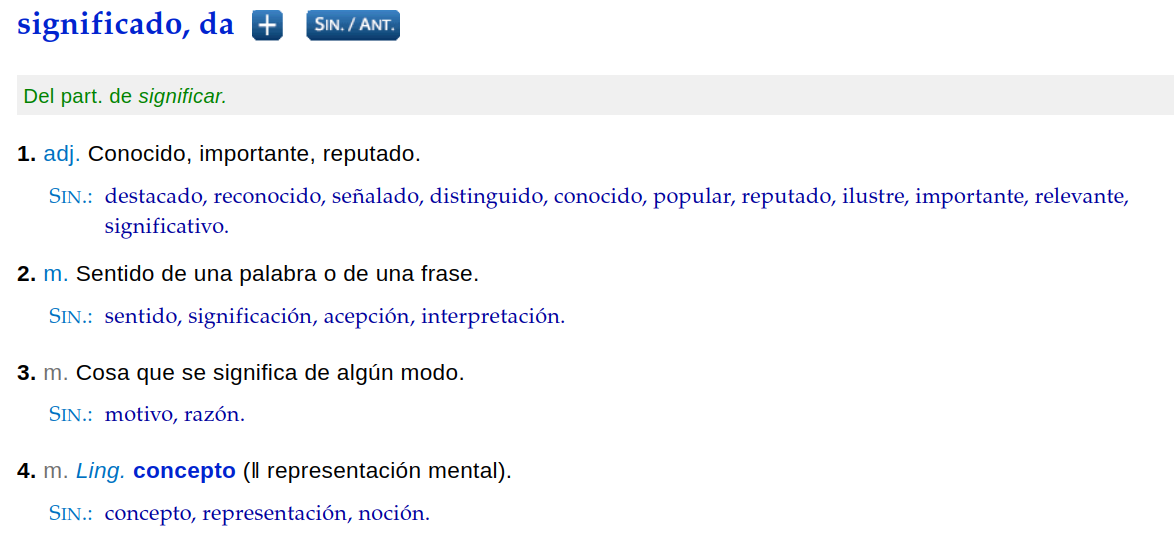


###Interpretación lingüística

- Significante -> Significado

Interpretamos el signo lingüístico

<img src="https://pymstatic.com/22726/conversions/diferencias-significado-significante-social.jpg" width=500>

## Old school semantics

Una forma de almacenar las relaciones semánticas de las palabras fue usando WordNets. Una suerte de diccionario + tesauro[1] para automatizar tareas de análisis de textos

[1]: https://es.wikipedia.org/wiki/Tesauro

In [92]:
import nltk

nltk.download("wordnet")
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [93]:
from nltk.corpus import wordnet as wn

bear = wn.synset("bear.n.01")
hyper = lambda s: s.hypernyms()
list(bear.closure(hyper))

[Synset('carnivore.n.01'),
 Synset('placental.n.01'),
 Synset('mammal.n.01'),
 Synset('vertebrate.n.01'),
 Synset('chordate.n.01'),
 Synset('animal.n.01'),
 Synset('organism.n.01'),
 Synset('living_thing.n.01'),
 Synset('whole.n.02'),
 Synset('object.n.01'),
 Synset('physical_entity.n.01'),
 Synset('entity.n.01')]

In [94]:
wn.synonyms("auto", lang="spa")

[['automóvil', 'carro', 'coche', 'máquina', 'turismo', 'vehículo'],
 ['decreto', 'edicto', 'sentencia'],
 ['misterio']]

### Desventajas

- Como las cosas basadas en reglas es díficil de mantener en el tiempo
  - Nuevas palabras
  - Subjetivo
  - Requiere muchisimo trabajo manual especializado

## Distributional Semantic Models (*DSMs*)

- Teoria linguistica que se basa en el hecho que dice que, palabras que ocurren en contextos similares tienen significados similares
> You shall know a word by the company it keeps - J.R. Firth

- Las palabras son representadas por vectores que capturan el patrón de co-ocurrencia de una palabra con muchas otras en el corpus
- Cada palabra sera un vector, tal que palabras que aparecen en contextos similares, seran representados por vectores similares

```json
¿Me regalas un 'caxitl' de agua?
El 'caxitl' de vidrio se rompió
Sirve la leche en el 'caxitl'
```

### ¿Qué significa *caxitl*?

<img src="https://www.sdpnoticias.com/resizer/Ri0ntQm5YWqR-2Mq0XKlBl_ExtI=/640x963/filters:format(jpg):quality(90)/cloudfront-us-east-1.images.arcpublishing.com/sdpnoticias/DGJILEMTYNBPZHO4D7KM63PPAY.jpg" height=300>

### Sabores de DSM

- Tenemos dos sabores grandes de DSM:
  - Count-based DSM
  - Prediction-based DSM

### Count-based

- Matriz con el patron de co-ocurrenca con otras palabras
  - Esto tiene la mejora de modelar las relaciones semanticas entre palabras
  - Aun tenemos vectores enormes (¿Cómo podriamos solucionar esto?)
- Se define una ventana $L$ para el contexto


_S = The dusty road ends nowhere. The dusty track ends there._

In [95]:
import nltk
import pandas as pd
import numpy as np
from collections import Counter
from itertools import combinations
from nltk.corpus import stopwords

In [96]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [97]:
S = "The dusty road ends nowhere. The dusty track ends there."

In [98]:
sentence = S.lower().split()
frecs = Counter(sentence)

In [99]:
frecs.most_common()

[('the', 2),
 ('dusty', 2),
 ('ends', 2),
 ('road', 1),
 ('nowhere.', 1),
 ('track', 1),
 ('there.', 1)]

In [100]:
indices = {token: idx for idx, token in enumerate(frecs.keys())}
indices

{'the': 0,
 'dusty': 1,
 'road': 2,
 'ends': 3,
 'nowhere.': 4,
 'track': 5,
 'there.': 6}

Para calcular las probabilidades de co-cocurrencia primero necesitamos la matriz de co-ocurrencia donde cada columna determina el contexto que comparte con cada palabra en las filas.

In [101]:
print(list(combinations(["hola", "que", "hace", "manito"], 2)))
print(list(combinations(sentence, 2)))

[('hola', 'que'), ('hola', 'hace'), ('hola', 'manito'), ('que', 'hace'), ('que', 'manito'), ('hace', 'manito')]
[('the', 'dusty'), ('the', 'road'), ('the', 'ends'), ('the', 'nowhere.'), ('the', 'the'), ('the', 'dusty'), ('the', 'track'), ('the', 'ends'), ('the', 'there.'), ('dusty', 'road'), ('dusty', 'ends'), ('dusty', 'nowhere.'), ('dusty', 'the'), ('dusty', 'dusty'), ('dusty', 'track'), ('dusty', 'ends'), ('dusty', 'there.'), ('road', 'ends'), ('road', 'nowhere.'), ('road', 'the'), ('road', 'dusty'), ('road', 'track'), ('road', 'ends'), ('road', 'there.'), ('ends', 'nowhere.'), ('ends', 'the'), ('ends', 'dusty'), ('ends', 'track'), ('ends', 'ends'), ('ends', 'there.'), ('nowhere.', 'the'), ('nowhere.', 'dusty'), ('nowhere.', 'track'), ('nowhere.', 'ends'), ('nowhere.', 'there.'), ('the', 'dusty'), ('the', 'track'), ('the', 'ends'), ('the', 'there.'), ('dusty', 'track'), ('dusty', 'ends'), ('dusty', 'there.'), ('track', 'ends'), ('track', 'there.'), ('ends', 'there.')]


In [102]:
def get_coocurrence_matrix(sentences: list[list[str]], indices: dict[str, int], n: int = 2) -> np.ndarray:
    matrix = np.zeros((len(indices), len(indices)))
    for sent in sentences:
        for term1, term2 in combinations(sent, 2):
            matrix[indices[term1], indices[term2]] += 1
            matrix[indices[term2], indices[term1]] += 1
    return matrix

In [103]:
coocurrence_matrix = get_coocurrence_matrix([sentence], indices)

In [104]:
C = pd.DataFrame(data=coocurrence_matrix, index=list(indices.keys()), columns=list(indices.keys()))
C

,the,dusty,road,ends,nowhere.,track,there.
the,2.0,4.0,2.0,4.0,2.0,2.0,2.0
dusty,4.0,2.0,2.0,4.0,2.0,2.0,2.0
road,2.0,2.0,0.0,2.0,1.0,1.0,1.0
ends,4.0,4.0,2.0,2.0,2.0,2.0,2.0
nowhere.,2.0,2.0,1.0,2.0,0.0,1.0,1.0
track,2.0,2.0,1.0,2.0,1.0,0.0,1.0
there.,2.0,2.0,1.0,2.0,1.0,1.0,0.0


##### Aplicandolo a un corpus grande

In [105]:
from nltk.corpus import brown
from nltk.stem import SnowballStemmer
from itertools import chain

In [106]:
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [107]:
brown.sents(categories=["government"])[0]

['The',
 'Office',
 'of',
 'Business',
 'Economics',
 '(',
 'OBE',
 ')',
 'of',
 'the',
 'U.S.',
 'Department',
 'of',
 'Commerce',
 'provides',
 'basic',
 'measures',
 'of',
 'the',
 'national',
 'economy',
 'and',
 'current',
 'analysis',
 'of',
 'short-run',
 'changes',
 'in',
 'the',
 'economic',
 'situation',
 'and',
 'business',
 'outlook',
 '.']

In [108]:
def normalize_sent(sentence: list[str]) -> list[str]:
    stemmer = SnowballStemmer("english")
    result = []
    return [
        stemmer.stem(word.lower())
        for word in sentence
        if word.isalpha() and
        word.lower() not in stopwords.words("english")
    ]

def normalize_corpus(corpus: list[list[str]]) -> list[list[str]]:
    return [
        normalize_sent(sent)
        for sent in corpus
        if len(normalize_sent(sent)) > 1
    ]

In [109]:
sentences = normalize_corpus(brown.sents(categories=["government"]))

In [110]:
sentences[:3]

[['offic',
  'busi',
  'econom',
  'obe',
  'depart',
  'commerc',
  'provid',
  'basic',
  'measur',
  'nation',
  'economi',
  'current',
  'analysi',
  'chang',
  'econom',
  'situat',
  'busi',
  'outlook'],
 ['develop',
  'analyz',
  'nation',
  'incom',
  'balanc',
  'intern',
  'payment',
  'mani',
  'busi',
  'indic'],
 ['measur',
  'essenti',
  'job',
  'present',
  'busi',
  'govern',
  'fact',
  'requir',
  'meet',
  'object',
  'expand',
  'busi',
  'improv',
  'oper',
  'economi']]

In [111]:
tokens = list(chain(*sentences))

In [112]:
freqs = Counter(tokens)
freqs.most_common(10)

[('state', 388),
 ('year', 290),
 ('develop', 193),
 ('may', 180),
 ('unit', 175),
 ('use', 152),
 ('govern', 151),
 ('new', 150),
 ('servic', 144),
 ('time', 137)]

In [113]:
index = {token: idx for idx, token in enumerate(freqs.keys())}
index

{'offic': 0,
 'busi': 1,
 'econom': 2,
 'obe': 3,
 'depart': 4,
 'commerc': 5,
 'provid': 6,
 'basic': 7,
 'measur': 8,
 'nation': 9,
 'economi': 10,
 'current': 11,
 'analysi': 12,
 'chang': 13,
 'situat': 14,
 'outlook': 15,
 'develop': 16,
 'analyz': 17,
 'incom': 18,
 'balanc': 19,
 'intern': 20,
 'payment': 21,
 'mani': 22,
 'indic': 23,
 'essenti': 24,
 'job': 25,
 'present': 26,
 'govern': 27,
 'fact': 28,
 'requir': 29,
 'meet': 30,
 'object': 31,
 'expand': 32,
 'improv': 33,
 'oper': 34,
 'inform': 35,
 'contact': 36,
 'director': 37,
 'washington': 38,
 'print': 39,
 'materi': 40,
 'made': 41,
 'avail': 42,
 'businessmen': 43,
 'economist': 44,
 'prompt': 45,
 'month': 46,
 'survey': 47,
 'week': 48,
 'supplement': 49,
 'period': 50,
 'includ': 51,
 'statist': 52,
 'per': 53,
 'year': 54,
 'field': 55,
 'superintend': 56,
 'document': 57,
 'technic': 58,
 'assist': 59,
 'small': 60,
 'communiti': 61,
 'administr': 62,
 'sba': 63,
 'guidanc': 64,
 'advic': 65,
 'sourc': 66,
 

In [114]:
coocurrence_brown = get_coocurrence_matrix(sentences, index)
coocurence_df = pd.DataFrame(data=coocurrence_brown, index=list(index.keys()), columns=list(index.keys()))
coocurence_df

,offic,busi,econom,obe,depart,commerc,provid,basic,measur,nation,...,jones,masteri,widest,potent,besieg,preclud,cadr,percept,lengthen,shadow
offic,16.0,12.0,3.0,1.0,17.0,10.0,3.0,2.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
busi,12.0,40.0,11.0,2.0,6.0,3.0,9.0,2.0,5.0,10.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
econom,3.0,11.0,8.0,2.0,17.0,3.0,4.0,7.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
obe,1.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
depart,17.0,6.0,17.0,1.0,16.0,5.0,4.0,2.0,1.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
preclud,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cadr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
percept,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
lengthen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


In [115]:
query = SnowballStemmer("english").stem("presidential")
coocurence_df[query].sort_values(ascending=False)

polici      3.0
appointe    3.0
polit       3.0
foreign     2.0
one         2.0
           ... 
tabul       0.0
exact       0.0
meant       0.0
drawn       0.0
shadow      0.0
Name: presidenti, Length: 3971, dtype: float64

## Word Embeddings

- En 2013 Mikolov et al. publican el paper: [Efficient Estimation of Word Representations in Vector Space](https://proceedings.neurips.cc/paper_files/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf)
- Muestran una forma eficiente de obtener DSM word-embeddings (Word2Vec):
    - CBOW
    - Skipgram
- De ahí surgieron variaciones
    - GloVe
    - fastText
    - ELMo

### Pre-trained Word Embbedings

In [27]:
import gensim.downloader as gensim_api

In [117]:
gensim_api.info(name_only=True)

{'corpora': ['semeval-2016-2017-task3-subtaskBC',
  'semeval-2016-2017-task3-subtaskA-unannotated',
  'patent-2017',
  'quora-duplicate-questions',
  'wiki-english-20171001',
  'text8',
  'fake-news',
  '20-newsgroups',
  '__testing_matrix-synopsis',
  '__testing_multipart-matrix-synopsis'],
 'models': ['fasttext-wiki-news-subwords-300',
  'conceptnet-numberbatch-17-06-300',
  'word2vec-ruscorpora-300',
  'word2vec-google-news-300',
  'glove-wiki-gigaword-50',
  'glove-wiki-gigaword-100',
  'glove-wiki-gigaword-200',
  'glove-wiki-gigaword-300',
  'glove-twitter-25',
  'glove-twitter-50',
  'glove-twitter-100',
  'glove-twitter-200',
  '__testing_word2vec-matrix-synopsis']}

In [118]:
word_vectors = gensim_api.load("glove-wiki-gigaword-300")

In [119]:
print("Information about vectors")
print(f"Tokens={word_vectors.vectors.shape[0]}")
print(f"Dimension de vectores={word_vectors.vectors.shape[1]}")

Information about vectors
Tokens=400000
Dimension de vectores=300


In [120]:
word_vectors.index_to_key[40:50]

['had', 'i', 'which', 'will', 'their', ':', 'or', 'its', 'one', 'after']

In [121]:
word_vectors["sun"][:10]

array([-0.052904, -0.52215 ,  0.61028 , -0.47123 , -0.63499 , -0.37179 ,
        0.28971 ,  0.34281 ,  0.30543 , -0.97355 ], dtype=float32)

In [122]:
word_vectors["moon"][:10]

array([-0.082002, -0.59169 ,  0.12508 , -0.13111 , -0.76635 ,  0.080209,
       -0.086779, -0.20525 ,  0.15209 , -0.93776 ], dtype=float32)

In [123]:
word_vectors.similarity("cat", "tree")

0.24567418

In [124]:
word_vectors.most_similar("obama", topn=10)

[('barack', 0.9254721999168396),
 ('mccain', 0.7590768337249756),
 ('bush', 0.7570988535881042),
 ('clinton', 0.7085603475570679),
 ('hillary', 0.6497915387153625),
 ('kerry', 0.6144053339958191),
 ('rodham', 0.6138635277748108),
 ('biden', 0.5940852165222168),
 ('gore', 0.5885976552963257),
 ('democrats', 0.5608304738998413)]

In [125]:
word_vectors.doesnt_match("car motor python oil mustang".split())

'python'

In [126]:
word_vectors.n_similarity(['mexican', 'market'], ['japanese', 'restaurant'])

0.49910524

In [127]:
vector = word_vectors['computer']
print(vector.shape)
print(vector[:10])

(300,)
[-0.27628   0.13999   0.098519 -0.64019   0.031988  0.10066  -0.18673
 -0.37129   0.5974   -2.0405  ]


In [128]:
word_vectors.distance("dog", "cat")

0.31832534074783325

In [129]:
# usa, mexico, australia
word_vectors.most_similar(positive=['london', 'australia'], negative=['england'])

[('sydney', 0.642557680606842),
 ('melbourne', 0.5613194108009338),
 ('australian', 0.5543507933616638),
 ('canberra', 0.5333121418952942),
 ('singapore', 0.5224897265434265),
 ('britain', 0.4611770808696747),
 ('jakarta', 0.4399236738681793),
 ('tokyo', 0.4353730380535126),
 ('downer', 0.4264604449272156),
 ('british', 0.4207894802093506)]

In [130]:
# animals (mr gifts)
word_vectors.most_similar(positive=["cat", "oink"], negative=["pig"])

[('humph', 0.35762909054756165),
 ('congeniality', 0.3523644804954529),
 ('scaredy', 0.3450161814689636),
 ('fennica', 0.3375328779220581),
 ('meow', 0.33696794509887695),
 ('tica', 0.3323996663093567),
 ('clank', 0.33106184005737305),
 ('jeepers', 0.32873043417930603),
 ('meows', 0.3263651728630066),
 ('purr', 0.326193630695343)]

#### Homónimos

In [131]:
word_vectors.most_similar("leaves")

[('leaf', 0.5564894080162048),
 ('stems', 0.554435670375824),
 ('leaving', 0.5414506196975708),
 ('leave', 0.5339293479919434),
 ('ends', 0.526331901550293),
 ('flowers', 0.48853448033332825),
 ('stalks', 0.47854119539260864),
 ('grows', 0.47765129804611206),
 ('arrives', 0.4741629362106323),
 ('takes', 0.47301045060157776)]

### Sinónimos y antónimos

In [132]:
word_vectors.distance("sun", "night")

0.7028950154781342

In [133]:
word_vectors.distance("sun", "light")

0.6154062747955322

### Analogías

In [134]:
word_vectors.most_similar(positive=['woman', 'grandfather'], negative=['man'])

[('grandmother', 0.7479126453399658),
 ('granddaughter', 0.6942362189292908),
 ('mother', 0.6758421659469604),
 ('daughter', 0.6645984649658203),
 ('niece', 0.6360315680503845),
 ('grandson', 0.6281304359436035),
 ('grandparents', 0.6169413328170776),
 ('aunt', 0.6147838234901428),
 ('paternal', 0.6040359735488892),
 ('father', 0.6014721393585205)]

In [135]:
word_vectors.most_similar(positive=['foot', 'glove'], negative=['hand'])

[('feet', 0.4071197509765625),
 ('10,000-square', 0.39483946561813354),
 ('40-foot', 0.39283332228660583),
 ('45,000-square', 0.39143508672714233),
 ('footer', 0.3891846239566803),
 ('footed', 0.3831801414489746),
 ('20-foot', 0.38169968128204346),
 ('14,000-square', 0.38004016876220703),
 ('meter', 0.3783116936683655),
 ('25-foot', 0.37663066387176514)]

#### Ejercicio Identificación de sesgos en vectores de palabras

- Corra el siguiente código con vectores pre-entrenados del modelo `glove-wiki-gigaword-300`:
    - Identifiqué las diferencias en la lista de palabras asociadas a hombres/mujeres y profesiones, explique como esto reflejaría un sesgo de genero
    - Utiliza la función `.most_similar()` para identificar analogías que exhiba el sesgo de los vectores pre-entrenados. Explica brevemente que sesgo identificar
    - ¿Como mitigarías estos sesgos al crear vectores de palabras con las técnicas vistas en la clase?

In [136]:
print(word_vectors.most_similar(positive=['man', 'hospital'], negative=['woman']))
print()
print(word_vectors.most_similar(positive=['woman', 'hospital'], negative=['man']))

[('hospitals', 0.5491076111793518), ('medical', 0.5077117681503296), ('ambulance', 0.44933536648750305), ('clinic', 0.4431297779083252), ('care', 0.4362875819206238), ('taken', 0.4251585304737091), ('wounded', 0.41932374238967896), ('doctor', 0.4124775528907776), ('treated', 0.41095998883247375), ('he', 0.41028308868408203)]

[('medical', 0.5818884372711182), ('clinic', 0.5779432058334351), ('doctors', 0.5731170177459717), ('nurse', 0.5709115862846375), ('hospitals', 0.5701820850372314), ('maternity', 0.5445928573608398), ('nursing', 0.538192629814148), ('patients', 0.5158903002738953), ('nurses', 0.49723029136657715), ('psychiatric', 0.49493834376335144)]


In [137]:
# man is a king like woman is a ?
print(word_vectors.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6713277101516724), ('princess', 0.5432624816894531), ('throne', 0.5386103987693787), ('monarch', 0.5347574949264526), ('daughter', 0.49802514910697937), ('mother', 0.49564430117607117), ('elizabeth', 0.4832652509212494), ('kingdom', 0.47747090458869934), ('prince', 0.4668239951133728), ('wife', 0.46473270654678345)]


### Evaluación

Word2Vec, al ser una tarea No Supervisada, carece de una forma objetiva de evaluación de resultados. Lo mejor es probar con heurísticas (AKA muevele hasta que funcione)

In [138]:
model = gensim_api.load("glove-twitter-25")

In [139]:
from gensim.test.utils import datapath

model.evaluate_word_pairs(datapath("wordsim353.tsv"))

(PearsonRResult(statistic=0.36409317762261983, pvalue=2.9690518748299425e-12),
 SignificanceResult(statistic=0.36452011505868487, pvalue=2.7887817384855327e-12),
 2.26628895184136)

In [ ]:
model.evaluate_word_analogies(datapath("questions-words.txt"))

(0.12924445558200726,
 [{'section': 'capital-common-countries',
   'correct': [('ATHENS', 'GREECE', 'BERLIN', 'GERMANY'),
    ('ATHENS', 'GREECE', 'CAIRO', 'EGYPT'),
    ('ATHENS', 'GREECE', 'HELSINKI', 'FINLAND'),
    ('ATHENS', 'GREECE', 'ISLAMABAD', 'PAKISTAN'),
    ('ATHENS', 'GREECE', 'MOSCOW', 'RUSSIA'),
    ('ATHENS', 'GREECE', 'TEHRAN', 'IRAN'),
    ('ATHENS', 'GREECE', 'TOKYO', 'JAPAN'),
    ('BAGHDAD', 'IRAQ', 'CAIRO', 'EGYPT'),
    ('BAGHDAD', 'IRAQ', 'HELSINKI', 'FINLAND'),
    ('BAGHDAD', 'IRAQ', 'ISLAMABAD', 'PAKISTAN'),
    ('BAGHDAD', 'IRAQ', 'OTTAWA', 'CANADA'),
    ('BAGHDAD', 'IRAQ', 'PARIS', 'FRANCE'),
    ('BAGHDAD', 'IRAQ', 'TOKYO', 'JAPAN'),
    ('BANGKOK', 'THAILAND', 'PARIS', 'FRANCE'),
    ('BANGKOK', 'THAILAND', 'TOKYO', 'JAPAN'),
    ('BERLIN', 'GERMANY', 'TOKYO', 'JAPAN'),
    ('BERN', 'SWITZERLAND', 'HELSINKI', 'FINLAND'),
    ('BERN', 'SWITZERLAND', 'TOKYO', 'JAPAN'),
    ('BERN', 'SWITZERLAND', 'BERLIN', 'GERMANY'),
    ('CAIRO', 'EGYPT', 'ISLAMABAD', 'P

### Entrenando nuestras propias representaciones vectoriales

![we](https://miro.medium.com/v2/resize:fit:2000/1*SYiW1MUZul1NvL1kc1RxwQ.png)

#### Obteniendo datos

![](https://data-and-the-world.onrender.com/posts/read-wikipedia-dump/dump_file_list.png)

Trabajaremos con una parte de la wikipedia en español. Usaremos la herramienta [wikiextractor](https://github.com/attardi/wikiextractor) y obtendremos los datos de la página: https://dumps.wikimedia.org/eswiki/

In [28]:
import urllib.request
from tqdm import tqdm

CORPORA_DIR = "word2vec/"

In [ ]:
#url = "https://dumps.wikimedia.org/eswiki/latest/eswiki-latest-pages-articles1.xml-p1p159400.bz2"
#url = "https://dumps.wikimedia.org/eswiki/latest/eswiki-latest-pages-articles2.xml-p159401p693323.bz2"
url = "https://dumps.wikimedia.org/eswiki/latest/eswiki-latest-pages-articles3.xml-p693324p1897740.bz2"
filename = CORPORA_DIR + "eswiki-articles3.bz2"

with tqdm(unit='B', unit_scale=True, unit_divisor=1024, miniters=1, desc=filename) as t:
    urllib.request.urlretrieve(url, filename, reporthook=lambda block_num, block_size, total_size: t.update(block_size))

In [ ]:
import multiprocessing
multiprocessing.cpu_count()

12

In [ ]:
!type C:\Windows\System32\drivers\etc\hosts

# Copyright (c) 1993-2009 Microsoft Corp.
#
# This is a sample HOSTS file used by Microsoft TCP/IP for Windows.
#
# This file contains the mappings of IP addresses to host names. Each
# entry should be kept on an individual line. The IP address should
# be placed in the first column followed by the corresponding host name.
# The IP address and the host name should be separated by at least one
# space.
#
# Additionally, comments (such as these) may be inserted on individual
# lines or following the machine name denoted by a '#' symbol.
#
# For example:
#
#      102.54.94.97     rhino.acme.com          # source server
#       38.25.63.10     x.acme.com              # x client host

# localhost name resolution is handled within DNS itself.
#	127.0.0.1       localhost
#	::1             localhost


In [ ]:
import os
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


class WikiSentencesExtractor:

    def __init__(self, directory: str, max_lines: int):
        self.directory = directory
        self.max_lines = max_lines

    @staticmethod
    def preprocess(text: str) -> list:
        if len(text) <= 3 or text.startswith("<"):
            return []
        text = text.lower()
        text = re.sub(f'[^\w\s]', '', text)

        words = word_tokenize(text, language="spanish")

        stop_words = set(stopwords.words("spanish"))
        words = [token for token in words if token not in stop_words]
        words = [token for token in words if token.isalpha() and len(token) > 2]
        return words

    def __iter__(self):
        total_sent_iterator = 0

        for subdir_letter in os.listdir(self.directory):
            file_path = os.path.join(self.directory, subdir_letter)
            for file_name in os.listdir(file_path):
                with open(os.path.join(file_path, file_name)) as file:
                    for line in file:
                        if total_sent_iterator == self.max_lines:
                            return
                        words = self.preprocess(line)
                        if not words:
                            continue
                        total_sent_iterator += 1
                        yield words

In [ ]:
directory = CORPORA_DIR + "eswiki-dump3"
os.listdir(directory)

In [ ]:
%%time
sentences = WikiSentencesExtractor(directory, 10)

In [ ]:
for sentence in sentences:
    print(sentence)

In [1]:
from gensim.models import word2vec

In [2]:
MODELS_DIR = "word2vec/"

In [3]:
from enum import Enum

class Algorithms(Enum):
    CBOW = 0
    SKIP_GRAM = 1

In [4]:
def load_model(model_path: str):
    try:
        print(model_path)
        return word2vec.Word2Vec.load(model_path)
    except:
        print(f"[WARN] Model not found in path {model_path}")
        return None

In [ ]:
def train_model(sentences: list, model_name: str, vector_size: int, window=5, workers=2, algorithm = Algorithms.CBOW):
    model_name_params = f"{model_name}-vs{vector_size}-w{window}-{algorithm.name}.model"
    model_path = MODELS_DIR + model_name_params
    if load_model(model_path) is not None:
        print(f"Already exists the model {model_path}")
        return load_model(model_path)
    print(f"TRAINING: {model_path}")
    if algorithm in [Algorithms.CBOW, Algorithms.SKIP_GRAM]:
        model = word2vec.Word2Vec(
            sentences,
            vector_size=vector_size,
            window=window,
            workers=workers,
            sg = algorithm.value,
            seed=42,
            )
    else:
        print("[ERROR] algorithm not implemented yet :p")
        return
    try:
        model.save(model_path)
    except:
        print(f"[ERROR] Saving model at {model_path}")
    return model

### CBOW

In [5]:
cbow_model = load_model(MODELS_DIR + "eswiki-md-300-CBOW.model")

word2vec/eswiki-md-300-CBOW.model


In [ ]:
%%time
cbow_model = train_model(
    WikiSentencesExtractor(directory, -1),
    "eswiki",
    vector_size=100,
    window=5,
    workers=2,
    algorithm=Algorithms.CBOW
)

### Skip gram

In [6]:
skip_gram_model = load_model(MODELS_DIR + "eswiki-xl-300-SKIP_GRAM.model")

word2vec/eswiki-xl-300-SKIP_GRAM.model


In [7]:
def report_stats(model) -> None:
    """Print report of a model"""
    print("Number of words in the corpus used for training the model: ", model.corpus_count)
    print("Number of words in the model: ", len(model.wv.index_to_key))
    print("Time [s], required for training the model: ", model.total_train_time)
    print("Count of trainings performed to generate this model: ", model.train_count)
    print("Length of the word2vec vectors: ", model.vector_size)
    print("Applied context length for generating the model: ", model.window)

### Operaciones con los vectores entrenados

Veremos operaciones comunes sobre vectores. Estos resultados dependeran del modelo que hayamos cargado en memoria

In [8]:
models = {
    Algorithms.CBOW: cbow_model,
    Algorithms.SKIP_GRAM: skip_gram_model,
}

In [9]:
model = models[Algorithms.SKIP_GRAM]

In [10]:
for index, word in enumerate(model.wv.index_to_key):
    if index == 100:
        break
    print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

word #0/280884 is años
word #1/280884 is dos
word #2/280884 is parte
word #3/280884 is año
word #4/280884 is ser
word #5/280884 is después
word #6/280884 is ciudad
word #7/280884 is primera
word #8/280884 is san
word #9/280884 is gran
word #10/280884 is nombre
word #11/280884 is primer
word #12/280884 is tras
word #13/280884 is historia
word #14/280884 is así
word #15/280884 is the
word #16/280884 is mismo
word #17/280884 is puede
word #18/280884 is tres
word #19/280884 is aunque
word #20/280884 is forma
word #21/280884 is además
word #22/280884 is nacional
word #23/280884 is vez
word #24/280884 is grupo
word #25/280884 is lugar
word #26/280884 is población
word #27/280884 is mayor
word #28/280884 is guerra
word #29/280884 is general
word #30/280884 is junto
word #31/280884 is sido
word #32/280884 is bajo
word #33/280884 is nueva
word #34/280884 is tiempo
word #35/280884 is mientras
word #36/280884 is embargo
word #37/280884 is partido
word #38/280884 is nuevo
word #39/280884 is españa

In [11]:
gato_vec = model.wv["gato"]
print(gato_vec[:10])
print(len(gato_vec))

[ 0.33817086  0.33588076  0.10757865 -0.20355384  0.11145781 -0.06611738
  0.15729965  0.03296756 -0.12041545  0.44173205]
300


In [15]:
try:
    agustisidad_vec = model.wv["agusticidad"]
except KeyError:
    print("OOV founded!")


OOV founded!


In [14]:
agustisidad_vec[:10]
len(agustisidad_vec)

NameError: name 'agustisidad_vec' is not defined

In [16]:
model.wv.most_similar("lisiado", topn=5)

[('hiriéndole', 0.8047760128974915),
 ('despertarlo', 0.7923995852470398),
 ('andrajoso', 0.7919625043869019),
 ('parashúrama', 0.7862868309020996),
 ('tullido', 0.786266565322876)]

Podemos ver como la similitud entre palabras decrece

In [17]:
word_pairs = [
    ("automóvil", "camión"),
    ("automóvil", "bicicleta"),
    ("automóvil", "cereal"),
    ("automóvil", "conde"),
]

for w1, w2 in word_pairs:
    print(f"{w1} - {w2} {model.wv.similarity(w1, w2)}")

automóvil - camión 0.5287835597991943
automóvil - bicicleta 0.44169914722442627
automóvil - cereal 0.1768796443939209
automóvil - conde 0.18753406405448914


In [18]:
# rey es a hombre como ___ a mujer
# londres es a inglaterra como ____ a vino
model.wv.most_similar(positive=['vida', 'enfermedad'], negative=['salud'])

[('vidas', 0.48832395672798157),
 ('infección', 0.4287223517894745),
 ('erdheimchester', 0.4097159206867218),
 ('alzhéimer', 0.4089084267616272),
 ('consunción', 0.4061967432498932),
 ('degenerativa', 0.4034663140773773),
 ('azaroso', 0.40266117453575134),
 ('protozoario', 0.4012756049633026),
 ('incurable', 0.4003390669822693),
 ('cirrosis', 0.39809009432792664)]

In [19]:
model.wv.doesnt_match(["disco", "música", "mantequilla", "cantante"])

'mantequilla'

In [20]:
model.wv.similarity("noche", "noches")

0.6196776

### Referencias

- [Word Embeddings - Lenia Voita](https://lena-voita.github.io/nlp_course/word_embeddings.html#pre_neural)
- [Standford NLP course 2025](https://web.stanford.edu/class/cs224n/)
- [Word2Vec Tuto](https://rare-technologies.com/word2vec-tutorial/)
- Partes del código utilizado para este notebook fueron tomados de trabajos de la [Dr. Ximena Gutierrez-Vasques](https://github.com/ximenina/) y el [Dr. Victor Mijangos](https://github.com/VMijangos/InformationRetrieval/blob/main/Notebooks/11%20PMI.ipynb)

#### Gensim

- [Corpus streaming on gensim](https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html#corpus-streaming-one-document-at-a-time)
- [Gensim docs](https://radimrehurek.com/gensim/auto_examples/index.html)

# 3. Práctica: Vectores a palabras

**Fecha de entrega: 16 de Marzo de 2025 @ 11:59pm**

Obtenga la matriz de co-ocurrencia para un corpus en español y realice los siguientes calculos:
- Las probabilidades conjuntas
$$p(w_i,w_j) = \frac{c_{i,j}}{\sum_i \sum_j c_{i,j}}$$
- Las probabilidades marginales
$$p(w_i) = \sum_j p(w_i,w_j)$$
- Positive Point Wise Mutual Information (PPMI):
$$PPMI(w_i,w_j) = \max\{0, \log_2 \frac{p(w_i,w_j)}{p(w_i)p(w_j)}\}$$

**Comparación de representaciones**

Aplica reducción de dimensionalidad (a 2D) de los vectores de la matríz con PPMI y de los vectores entrenados en español:

- Realiza un plot de 100 vectores aleatorios (que esten tanto en la matríz como en los vectores entrenados)
- Compara los resultados de los plots:
    - ¿Qué representación dirías que captura mejor relaciones semánticas?
    - Realiza un cuadro comparativo de ambos métodos con ventajas/desventajas

### 📁 [Carpeta con vectores](https://drive.google.com/drive/folders/1reor2FGsfOB6m3AvfCE16NOHltAFjuvz?usp=drive_link)

### Carga de modelos pre-entrenados

In [36]:
from datasets import load_dataset
import re
from sklearn.decomposition import PCA
import itertools
import random
from collections import Counter, defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from scipy.sparse import dok_matrix
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from gensim.models import word2vec
import numpy as np
import spacy
nlp = spacy.load("es_core_news_sm")
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
def load_model(model_path: str):
    try:
        print(model_path)
        return word2vec.Word2Vec.load(model_path)
    except:
        print(f"[WARN] Model not found in path {model_path}")
        return None

In [23]:
print(MODELS_DIR)
model_name = "eswiki-md-300-CBOW.model"
model = load_model(MODELS_DIR + model_name)

word2vec/
word2vec/eswiki-md-300-CBOW.model


In [24]:
report_stats(model)

Number of words in the corpus used for training the model:  500000
Number of words in the model:  106423
Time [s], required for training the model:  325.74893600800715
Count of trainings performed to generate this model:  1
Length of the word2vec vectors:  300
Applied context length for generating the model:  5


In [25]:
ds = load_dataset("mathigatti/spanish_imdb_synopsis")

In [26]:
data = ds['train'].data['description'].to_pandas()
data = pd.DataFrame(data)
data.rename(columns = {"description":"text"}, inplace=True)

In [27]:
def preprocess_text(text):
    """Limpia el texto eliminando puntuación, convirtiendo a minúsculas y aplicando lematización con spaCy."""
    stop_words = set(stopwords.words("spanish"))
    
    # Eliminar puntuación y convertir a minúsculas
    text = re.sub(r"[^\w\s]", "", text.lower())
    
    # Procesar texto con spaCy
    doc = nlp(text)
    
    # Lematización y eliminación de stopwords
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_punct]
    true_tokens = []
    
    for token in tokens:
        if len(token.split()) == 1:
            true_tokens.append(token)
        elif 1 < len(token.split()):
            true_tokens.append(token.split()[0])
    
    return true_tokens

def build_cooccurrence_matrix(texts, window_size=2):
    """Construye una matriz de co-ocurrencias usando una ventana de contexto."""
    vocab = set(itertools.chain(*texts))
    vocab_size = len(vocab)
    word_to_id = {word: i for i, word in enumerate(vocab)}
    
    cooccurrence_matrix = dok_matrix((vocab_size, vocab_size), dtype=np.float32)
    
    for tokens in texts:
        for i, word in enumerate(tokens):
            word_id = word_to_id[word]
            start, end = max(0, i - window_size), min(len(tokens), i + window_size + 1)
            
            for j in range(start, end):
                if i != j:  
                    cooccurrence_matrix[word_id, word_to_id[tokens[j]]] += 1
                    
    return cooccurrence_matrix, word_to_id

def compute_pmi(cooccurrence_matrix, word_to_id):
    """Calcula la matriz de PMI a partir de la matriz de co-ocurrencias."""
    total_occurrences = cooccurrence_matrix.sum()
    word_counts = np.array(cooccurrence_matrix.sum(axis=1)).flatten()
    
    pmi_matrix = dok_matrix(cooccurrence_matrix.shape, dtype=np.float32)
    
    for (i, j), count in cooccurrence_matrix.items():
        p_ij = count / total_occurrences
        p_i = word_counts[i] / total_occurrences
        p_j = word_counts[j] / total_occurrences
        pmi_value = np.log2(p_ij / (p_i * p_j)) if p_ij > 0 else 0
        pmi_matrix[i, j] = max(0, pmi_value)  # PMI no negativa
    
    return pmi_matrix

# === Uso con DataFrame ===
def process_dataframe(df, column_name):
    """Procesa un DataFrame y calcula la matriz PMI."""
    # Preprocesar cada texto en la columna
    processed_texts = df[column_name].apply(preprocess_text).tolist()
    
    # Construir matriz de co-ocurrencias
    cooccurrence_matrix, word_to_id = build_cooccurrence_matrix(processed_texts, window_size=2)
    
    # Calcular PMI
    pmi_matrix = compute_pmi(cooccurrence_matrix, word_to_id)
    
    return pmi_matrix, word_to_id

pmi_matrix, word_to_id = process_dataframe(data, "text")
vocab = list(word_to_id.keys())

In [28]:
pmi = pmi_matrix.toarray()

In [29]:
vecs_word2vec = []
vecs_pmi = []

j = 0
while len(vecs_word2vec) < 100 or len(vecs_pmi) < 100:
    try:
        vecs_word2vec.append(model.wv[vocab[j]])
        vecs_pmi.append(pmi[word_to_id[vocab[j]]])
    except:
        pass
    j += 1

In [ ]:
pca_w2v = PCA(n_components=2)

vecs_word2vec_pca = pca.fit_transform(vecs_word2vec)
vecs_pmi_pca = pca.fit_transform(vecs_pmi)

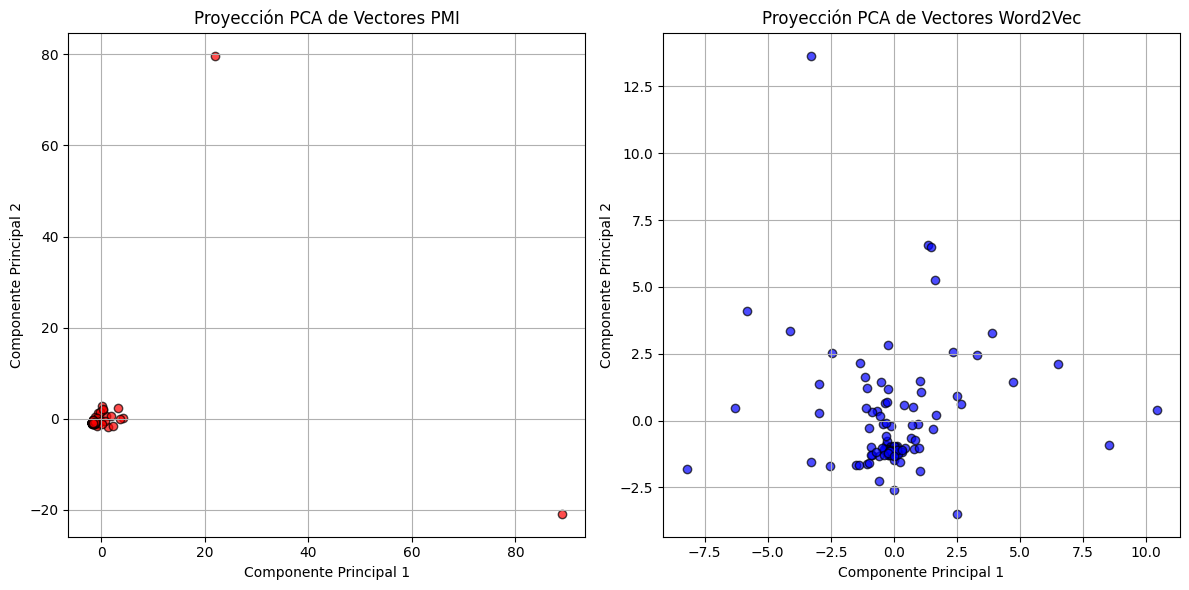

In [47]:
# Crear el subplot con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico PMI
axes[0].scatter(vecs_pmi_pca[:, 0], vecs_pmi_pca[:, 1], color="red", edgecolors="black", alpha=0.7)
axes[0].set_title("Proyección PCA de Vectores PMI")
axes[0].set_xlabel("Componente Principal 1")
axes[0].set_ylabel("Componente Principal 2")
axes[0].grid(True)

# Gráfico Word2Vec
axes[1].scatter(vecs_word2vec_pca[:, 0], vecs_word2vec_pca[:, 1], color="blue", edgecolors="black", alpha=0.7)
axes[1].set_title("Proyección PCA de Vectores Word2Vec")
axes[1].set_xlabel("Componente Principal 1")
axes[1].set_ylabel("Componente Principal 2")
axes[1].grid(True)

# Ajustar el espacio entre los subplots
plt.tight_layout()
plt.show()

1. _¿Qué representación captura mejor relaciones semánticas?_

Word2Vec con PCA parece capturar mejor las relaciones semánticas entre palabras, ya que se observa una distribución más uniforme de los puntos en el espacio bidimensional, lo que indica que los vectores mantienen relaciones más ricas en términos de significado. PMI con PCA, en cambio, muestra una agrupación densa con algunos puntos muy alejados del centro. Esto puede sugerir que algunas palabras tienen co-ocurrencias muy altas, pero la distribución no es tan rica en información semántica global como Word2Vec.

_Comparación de PMI vs. Word2Vec con PCA_

| **Criterio**               | **PMI + PCA** | **Word2Vec + PCA** |
|----------------------------|--------------|--------------------|
| **Captura de relaciones semánticas** | Depende estrictamente de la co-ocurrencia de palabras en un contexto determinado. Es útil para encontrar asociaciones directas pero no capta bien relaciones más profundas como sinónimos o analogías. | Aprende relaciones distribuidas a partir del contexto, permitiendo capturar significados más ricos. Es capaz de modelar analogías y sinónimos de manera más efectiva. |
| **Distribución en el espacio** | Tiende a generar una estructura más dispersa, con grupos densos de palabras altamente correlacionadas y algunos puntos extremos debido a palabras con co-ocurrencias raras pero significativas. | Los vectores tienden a distribuirse de forma más uniforme, lo que facilita la identificación de patrones semánticos. |
| **Robustez ante ruido** | Es sensible a datos escasos; si una palabra rara aparece solo unas pocas veces, su valor PMI puede ser extremo y afectar la representación global. | Al estar basado en modelos de aprendizaje profundo, puede aprender representaciones más robustas y es menos afectado por palabras con baja frecuencia. |
| **Computacionalmente eficiente** | Requiere solo cálculos de frecuencias y factorizaciones, por lo que es más rápido en corpus pequeños o medianos. Sin embargo, la matriz de co-ocurrencia puede volverse enorme en corpus grandes. | Es más costoso computacionalmente ya que requiere entrenar redes neuronales para aprender las representaciones de palabras. Sin embargo, modelos preentrenados pueden reutilizarse. |
| **Explicabilidad** | Los valores son interpretables ya que reflejan directamente la co-ocurrencia de palabras. Facilita análisis basados en estadística y teoría de información. | Los vectores resultantes son menos interpretables debido a que aprenden representaciones latentes. Se necesita visualizar su comportamiento en tareas específicas para comprender su utilidad. |
| **Dependencia del corpus** | Alta dependencia de la distribución de frecuencias en el corpus. No puede generalizar bien si el corpus cambia. | Menos dependiente de la frecuencia exacta y más capaz de aprender representaciones generales del significado de las palabras. |
| **Adecuado para** | Análisis exploratorio de co-ocurrencias, identificación de palabras clave en dominios específicos y visualización de relaciones directas. | Modelos de NLP más avanzados, sistemas de recomendación, clasificación de texto y cualquier tarea que requiera capturar significado profundo. |